In [1]:
import os
import gc
import re

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import wordcloud
import random

from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from catboost import CatBoostClassifier, Pool
from collections import defaultdict

In [ ]:
# !pip install catboost
# !pip install pyarrow
# !pip install nltk
# !pip install wordcloud
# !pip install xgboost
# !pip install scikit-learn

## Data Preprocessing

In [79]:
# Set the seed for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Fixed Seed

In [80]:
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# # parquet으로 저장 함수, csv보다 매우 빠르게 데이터 처리가 가능합니다 :)
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()                            #garbage collect
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

trainOrigin = pd.read_parquet('train.parquet')
testOrigin = pd.read_parquet('test.parquet')

train Done.
test Done.


In [4]:
# train 복사
train = trainOrigin.copy()
test = testOrigin.copy()

In [ ]:
from autogluon.tabular import TabularPredictor

auto=pd.read_csv(train, encoding='cp949')
train_auto, test_auto =  train_test_split(auto, train_size = 0.7, random_state =333,stratify=auto['first_party_winner'])

# autogluon 
predictor = TabularPredictor(label='first_party_winner').fit(train_data=auto[['first_party', 'second_party','facts', 'first_party_winner']])

In [85]:
label_train_x = train.drop(columns=['ID','first_party', 'second_party']) # 필요없는 칼럼 제거
label_train_y = train['first_party_winner'] # Delay 값이 target

# train.drop(columns=['ID','first_party', 'second_party'], inplace=True)
# test.drop(columns=['ID','first_party', 'second_party'], inplace=True)

In [86]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [87]:
test_x = test.drop(columns=['ID','first_party', 'second_party']) # 필요없는 칼럼 제거
test_x.head()

,facts
0,The 1984 Bail Reform Act allowed the federal c...
1,Lexecon Inc. was a defendant in a class action...
2,"In 2002 and 2003, Fox Television Stations broa..."
3,During his trial for armed robbery of a federa...
4,"In 1993, a magistrate judge issued a warrant a..."


In [88]:
## label_train 데이터로 unlabel 데이터의 레이블링을 진행
### 데이터 불균형 처리할 필요가 있음
label_train_y.value_counts()

first_party_winner
1    1649
0     829
Name: count, dtype: int64

In [89]:
## sklearn 의 selfTraingClassifier 이용
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier

In [98]:
stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    threshold = 0.9,
    verbose = True)
stclf.fit(label_train_x, label_train_y) # label데이터로 학습

ValueError: could not convert string to float: 'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n'

## 자연어처리

In [15]:

df = train1[['facts', 'first_party_winner']]
df_target = df[['first_party_winner']]

df_nlp = pd.DataFrame(df[['facts']], columns=['facts'])
# df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True) # 특수문자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'\d', '', regex=True)       # 숫자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'[^\w\s]', '', regex=True)

df_nlp

,facts
0,On June Phil St Amant a candidate for public...
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,On April in Selma Alabama an intruder broke ...
...,...
2473,Congress amended the Clean Air Act through the...
2474,Alliance Bond Fund Inc an investment fund purc...
2475,In the District Court sentenced Manuel D Pegu...
2476,On March Enrico St Cyr a lawful permanent re...


In [16]:
df_target.value_counts()

first_party_winner
1                     1649
0                      829
Name: count, dtype: int64

In [17]:
# import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [12]:
# from nltk.tokenize import WhitespaceTokenizer
# # 공백 단위로 쪼개기
# corpus = df_nlp1["facts"]
# Tokenizer=WhitespaceTokenizer()
# lst_tokens = Tokenizer.tokenize(str(corpus))
# lst_tokens

In [18]:

# 사용자 불용어 + 기본 제공 불용어 생성
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, user_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    if user_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    user_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [19]:
# 사용자 불용어 제작
user_stopwords = set(["appeal","filed","affirmed","held","u","state","supreme","federal","circuit","district", "law", "court", "case", "plaintiff", "defendant",
                "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding",
                "litigation", "party", "motion", "action", "suit", "claim", "issue",
                "fact", "hearing", "judgment", "order", "allegation", "argument",
                "brief", "charge", "complaint", "contract", "crime", "decision", "defense",
                "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal",
                "liability", "matter", "notice", "opinion", "plea", "point", "policy", "practice",
                "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict",
                'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph"
                "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation",
                "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty",
                "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal",
                "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation",
                "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule",
                "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment",
                "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal",
                "bail", "contempt", "conviction", "felony", "parole", "sentence",
                "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor",
                "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor",
                "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer",
                "insured", "beneficiary", "fiduciary", "principal", "agent"])

In [20]:
# NLTK가 제공 기본 불용어
lst_stopwords = nltk.corpus.stopwords.words("english")

In [21]:
len(user_stopwords)

153

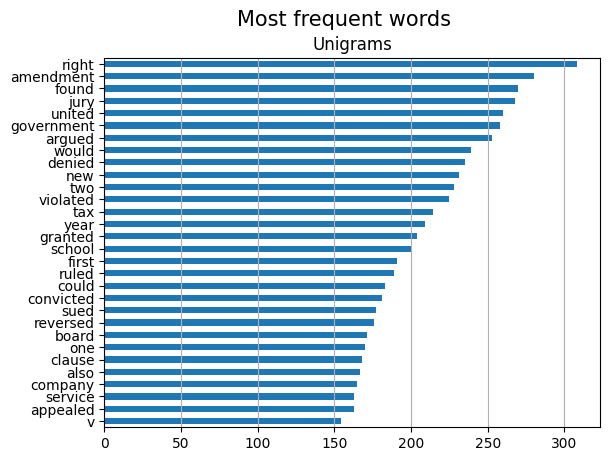

<Figure size 3000x2400 with 0 Axes>

In [22]:
df_nlp["facts_clean"] = df_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
df_nlp2 = df_nlp.join(df_target)
def freq(n):
    corpus = df_nlp2[df_nlp2["first_party_winner"]== n]["facts_clean"]
    temp = corpus.str.cat(sep=" ")
    wdTmp = utils_preprocess_text(temp, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords)
    lst_tokens = nltk.tokenize.word_tokenize(wdTmp)
    fig, ax = plt.subplots(1, 1)
    fig.suptitle("Most frequent words", fontsize=15)
    figure(figsize=(30, 24))
    
    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                        kind="barh", title="Unigrams", ax=ax, 
                        legend=False).grid(axis='x')

    ax.set(ylabel=None)
    plt.show()

    # n회 미만 단어 제거
    newL = []
    for word, freq in dic_words_freq.most_common():
        if freq <= 2:
            newL.append(word)
    user_stopwords.update(newL)
        
    return newL

lost = freq(0)

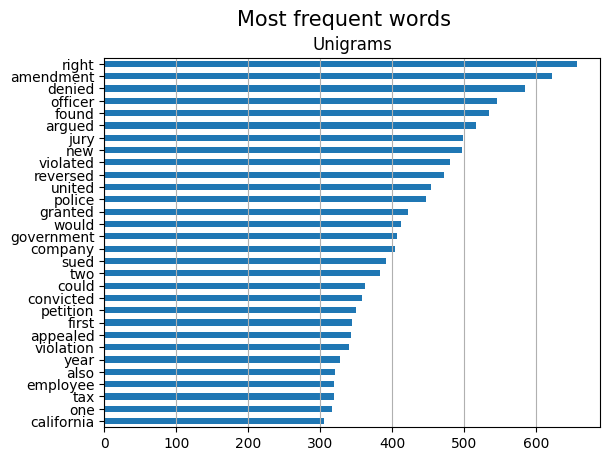

<Figure size 3000x2400 with 0 Axes>

In [23]:
won = freq(1)

In [24]:
len(user_stopwords)

10916

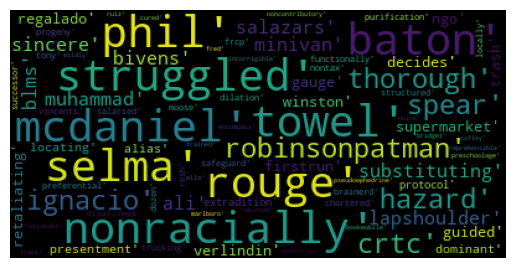

In [25]:
# import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc = wc.generate(str(won))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

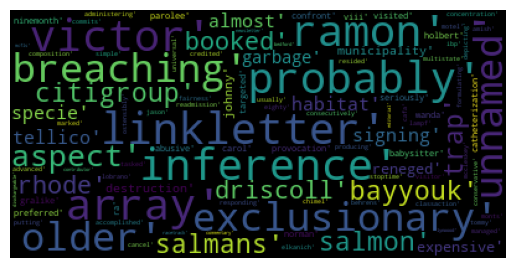

In [26]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc0 = wc0.generate(str(lost))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

## Preprocessing ENDS && MODELING STARTS

In [27]:
df_nlp2
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [28]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.3)

In [29]:
X_train.count(), X_test.count(), y_train.count(), y_test.count()

(1734, 744, 1734, 744)

In [30]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#REGRESSION

In [31]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [32]:
lr.score(X_test, y_test)

0.6599462365591398

#XGBoost

In [34]:
# !pip install xgboost

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
                    booster = 'gbtree',
                    scale_pos_weight=0.25,
                    learning_rate=0.01,  
                    colsample_bytree = 0.7,
                    subsample = 0.5,
                    max_delta_step = 3,
                    reg_lambda = 2,
                    objective='binary:logistic',
                    n_estimators=818, 
                    max_depth=8,
                    )


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [34]:
y_pred = xgb.predict_proba(X_test)
y_pred

array([[0.6998857 , 0.3001143 ],
       [0.42501616, 0.57498384],
       [0.7535372 , 0.2464628 ],
       ...,
       [0.70580333, 0.29419667],
       [0.46026444, 0.53973556],
       [0.5885062 , 0.4114938 ]], dtype=float32)

In [35]:
xgb.score(X_test, y_test)

0.46236559139784944

In [36]:

tfidfv = TfidfVectorizer().fit(train['facts'])
print(tfidfv.vocabulary_)
print("="*100)
print(tfidfv.transform(train['facts']).toarray())
print("="*100)
print(tfidfv.fit_transform(train['facts']).toarray())
tfidfv

{'on': 11300, 'june': 8968, '27': 352, '1962': 233, 'phil': 11996, 'st': 14991, 'amant': 1383, 'candidate': 2920, 'for': 6763, 'public': 12745, 'office': 11251, 'made': 9834, 'television': 15696, 'speech': 14902, 'in': 8202, 'baton': 2158, 'rouge': 13907, 'louisiana': 9745, 'during': 5518, 'this': 15846, 'accused': 922, 'his': 7811, 'political': 12180, 'opponent': 11342, 'of': 11235, 'being': 2243, 'communist': 3652, 'and': 1456, 'involved': 8711, 'criminal': 4314, 'activities': 972, 'with': 17250, 'the': 15798, 'head': 7642, 'local': 9656, 'teamsters': 15662, 'union': 16453, 'finally': 6612, 'implicated': 8153, 'herman': 7738, 'thompson': 15850, 'an': 1433, 'east': 5570, 'deputy': 4845, 'sheriff': 14489, 'scheme': 14152, 'to': 15937, 'move': 10652, 'money': 10553, 'between': 2321, 'successfully': 15317, 'sued': 15326, 'defamation': 4640, 'first': 6651, 'circuit': 3355, 'court': 4233, 'appeals': 1564, 'reversed': 13694, 'holding': 7848, 'that': 15797, 'did': 5001, 'not': 11076, 'show':

TfidfVectorizer()

   Probability of Negative Class  Probability of Positive Class
0                       0.699886                       0.300114
1                       0.425016                       0.574984
2                       0.753537                       0.246463
3                       0.655882                       0.344118
4                       0.462689                       0.537311


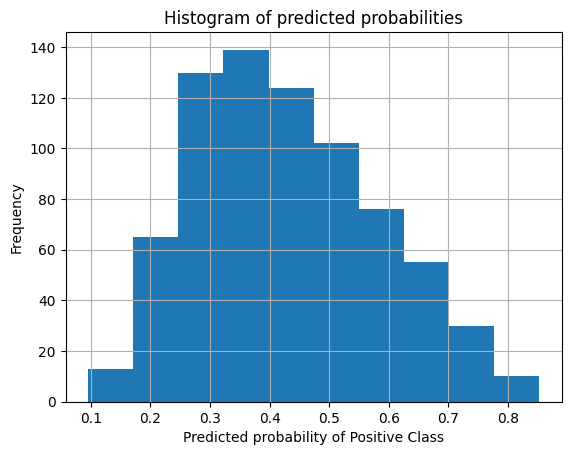

In [37]:
# Convert prediction results to a DataFrame
df_pred = pd.DataFrame(y_pred, columns=['Probability of Negative Class', 'Probability of Positive Class'])

# Print the first few rows
print(df_pred.head())

# Plot a histogram of probabilities for the positive class
df_pred['Probability of Positive Class'].hist()
plt.xlabel('Predicted probability of Positive Class')
plt.ylabel('Frequency')
plt.title('Histogram of predicted probabilities')
plt.show()


In [38]:
# Convert tf-idf array to DataFrame
df_tfidf = pd.DataFrame(tfidfv.transform(train['facts']).toarray(), columns=tfidfv.get_feature_names_out())
data_final = pd.concat([df_tfidf,df_nlp2["first_party_winner"]],axis=1,join='inner')
# print(df_tfidf.head())
terms = tfidfv.get_feature_names_out()
data_final

,00,000,0029,01,0136,019,027,03,032,04,...,zivotofsky,zone,zoned,zones,zoning,zubik,zuni,zurich,zurko,first_party_winner
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2474,0.0,0.046666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2476,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']), data_final['first_party_winner'], test_size=0.3,random_state=0)

In [40]:
# LDA 학습, 단어의 의미구조 파악
# 30초정도 걸림
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=1) # n_component : 토픽 갯수
lda_data = lda.fit_transform(X_train)

In [41]:
# LDA 학습 결과 보기

def get_topics(components, feature_names, n=5): # n: n개 출력
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda.components_,terms)

# 결과값은 토픽과 토픽의 기여도에 대한 데이터

Topic 1: [('ford', 0.71), ('cwa', 0.54), ('mcburney', 0.53), ('nea', 0.51), ('archers', 0.5)]
Topic 2: [('texas', 1.46), ('procedural', 1.11), ('remain', 1.02), ('tailored', 0.99), ('portion', 0.97)]
Topic 3: [('rape', 0.57), ('wilson', 0.55), ('perkins', 0.54), ('fpc', 0.52), ('thereafter', 0.52)]
Topic 4: [('stock', 1.56), ('policies', 1.07), ('sec', 0.9), ('1934', 0.85), ('amgen', 0.74)]
Topic 5: [('perry', 0.71), ('adelaide', 0.53), ('tolling', 0.51), ('brady', 0.5), ('equitable', 0.45)]
Topic 6: [('anza', 0.64), ('alice', 0.62), ('fox', 0.47), ('crenshaw', 0.45), ('kelly', 0.42)]
Topic 7: [('gray', 0.72), ('agee', 0.69), ('lindh', 0.61), ('cleveland', 0.59), ('fletcher', 0.56)]
Topic 8: [('surgery', 0.69), ('science', 0.6), ('fee', 0.59), ('creation', 0.55), ('utah', 0.5)]
Topic 9: [('chavis', 0.77), ('mcdonough', 0.69), ('davis', 0.59), ('ortiz', 0.55), ('clayton', 0.5)]
Topic 10: [('rummel', 0.67), ('supervisor', 0.6), ('bruton', 0.57), ('crawford', 0.55), ('evans', 0.52)]
Topic

In [42]:
# XG부스트 모델 적용하기
from sklearn.metrics import accuracy_score
# param_dict = {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300}
# lda_data = X_train
# lda = vectorizeTF
model = XGBClassifier(scale_pos_weight=0.3) # **param_dict
x = pd.DataFrame(data=lda_data)
model.fit(x, y_train)

# 테스트 lda 적용
xtest = pd.DataFrame(data=lda.transform(X_test))


In [43]:
accuracy_score(y_train, model.predict(x))

0.961361014994233

In [44]:
y_pred = model.predict(xtest)

In [45]:
# 평가

from sklearn.metrics import f1_score
accuracy = accuracy_score(y_test, y_pred) # 정확도
print("Accuracy: %.2f%%" % (accuracy * 100.0)) 
f1_score(y_test, y_pred) # 정밀도와 재현율의 조화평균

Accuracy: 55.65%


0.6590909090909091

In [39]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# #train_nlp2 = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
# xfeatures = df_nlp2['facts_clean']
# ylabel = df_nlp2['first_party_winner']

In [40]:
# vectorizer = TfidfVectorizer()
# def get_vector(vectorizer, df, train_mode):
#     if train_mode:
#         X_facts = vectorizer.fit_transform(df['facts'])
#     else:
#         X_facts = vectorizer.transform(df['facts'])
#     X_party1 = vectorizer.transform(df['first_party'])
#     X_party2 = vectorizer.transform(df['second_party'])
    
#     X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
#     return X

In [41]:
# X_train = get_vector(vectorizer, train, True)
# Y_train = train["first_party_winner"]
# X_test = get_vector(vectorizer, test, False)

## Inference & Submission

In [46]:
dfTest = pd.DataFrame(test['facts'])
dfTest['facts'] = dfTest['facts'].str.replace(r'[^\w\s]', '', regex=True)
dfTest['facts'] = dfTest['facts'].str.replace(r'\d', '', regex=True)  # 숫자 제거
dfTest["facts_clean"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,facts_clean,first_party_winner
0,The Bail Reform Act allowed the federal court...,reform allowed court prior government could pr...,0
1,Lexecon Inc was a defendant in a class action ...,lexecon inc class lawsuit usc lawsuit transfer...,0
2,In and Fox Television Stations broadcast the...,fox television station broadcast billboard mus...,0
3,During his trial for armed robbery of a federa...,armed robbery federally saving loan associatio...,0
4,In a magistrate judge issued a warrant author...,issued warrant authorizing search paul erma be...,0
...,...,...,...
1235,According to Executive Order No signed by Pre...,according executive signed president george h ...,0
1236,Section a of the Clean Air Act CAA requires th...,clean air caa requires environmental protectio...,0
1237,Linda Matteo and John Madigan created a plan f...,matteo john created plan utilizing million fun...,0
1238,In the North Carolina Board of Agriculture ad...,north carolina board adopted required apple sh...,0


In [47]:
count_matrix_test = tfidfv.transform(dfTest['facts_clean'])
count_array_test = count_matrix_test.toarray()
data_final_test = pd.DataFrame(data=count_array_test,columns = tfidfv.get_feature_names_out())
data_final_test = pd.concat([data_final_test,dfTest["first_party_winner"]],axis=1,join='inner')
data_final_test

,00,000,0029,01,0136,019,027,03,032,04,...,zivotofsky,zone,zoned,zones,zoning,zubik,zuni,zurich,zurko,first_party_winner
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [48]:
X_test = data_final_test.drop(columns=['first_party_winner'])
y_test = data_final_test['first_party_winner']

In [49]:
x_lda_test = pd.DataFrame(data=lda.transform(X_test))
y_pred_test = model.predict(x_lda_test)
# predictionsTest = [round(value) for value in y_pred_test]
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])

In [50]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done


In [51]:
predcsv.value_counts()

first_party_winner
1                     884
0                     356
Name: count, dtype: int64